# Car Manufacturer Fuel Efficiency Prediction
This notebook aims to predict the fuel efficiency (MPG) of cars using a linear regression model. The objective is to identify key factors that contribute to higher fuel efficiency, helping a car manufacturer design more energy-efficient vehicles.


## Step 1: Data Loading and Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

# Load the dataset
file_path = 'car.csv'
df = pd.read_csv(file_path)
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,US Made
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


## Step 2: Data Cleaning and Handling Missing Values
After loading the data, we check for missing values, particularly in the Horsepower column. Missing values can introduce bias and reduce the quality of our model, so we will impute the missing values using the median. Imputation with the median is useful when the data contains outliers, as it preserves the distribution without being affected by extreme values.


In [2]:
# Convert Horsepower column to numeric and handle non-numeric values
df['Horsepower'] = pd.to_numeric(df['Horsepower'], errors='coerce')

# Impute missing values in Horsepower using the median
df['Horsepower'].fillna(df['Horsepower'].median(), inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    398 non-null    float64
 4   Weight        398 non-null    int64  
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   US Made       398 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 25.0 KB


## Step 3: Outlier Detection and Capping
Outliers can distort a linear regression model's results by giving undue weight to extreme values. In this step, we use boxplots to visualize outliers and apply capping at the 1st and 99th percentiles to limit their influence. The boxplots below show the outliers before and after capping.


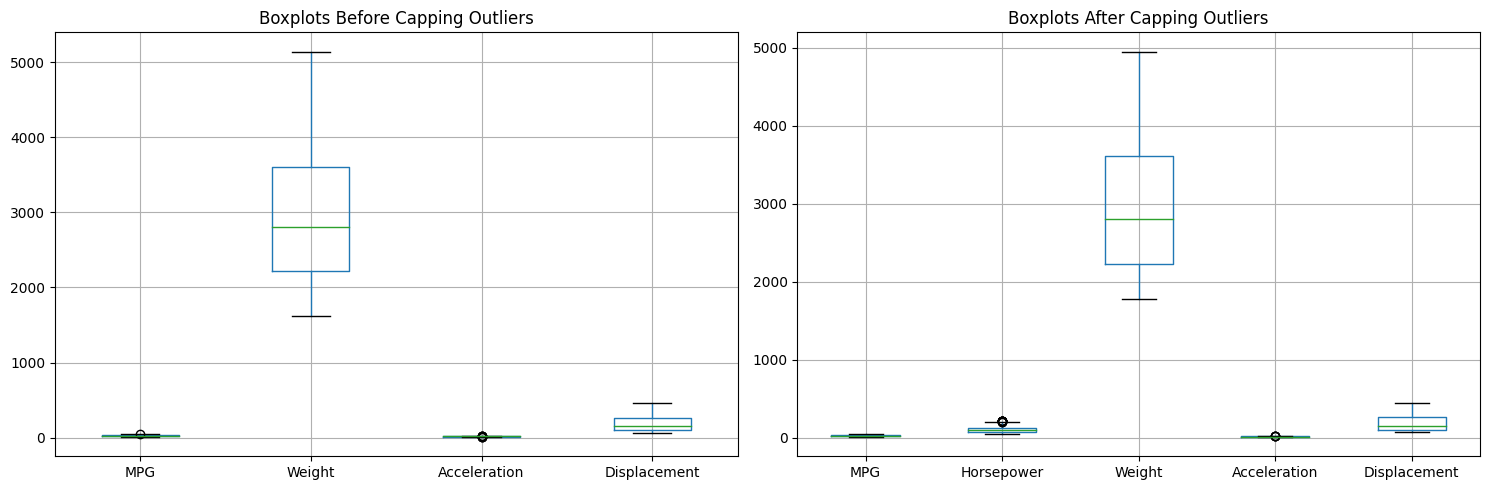

In [3]:
# Cap outliers to the 1st and 99th percentiles for relevant numeric columns
def cap_outliers(series):
    lower_bound = series.quantile(0.01)
    upper_bound = series.quantile(0.99)
    return series.clip(lower=lower_bound, upper=upper_bound)

numeric_columns = ['MPG', 'Horsepower', 'Weight', 'Acceleration', 'Displacement']
df[numeric_columns] = df[numeric_columns].apply(cap_outliers)

# Plot boxplots before and after capping outliers
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
df_before_capping = pd.read_csv(file_path)
df_before_capping[numeric_columns].boxplot()
plt.title('Boxplots Before Capping Outliers')

plt.subplot(1, 2, 2)
df[numeric_columns].boxplot()
plt.title('Boxplots After Capping Outliers')
plt.tight_layout()
plt.show()


## Step 4: Multicollinearity Check and Feature Selection
Multicollinearity occurs when two or more independent variables are highly correlated with each other. This can cause problems in linear regression, as it becomes difficult to determine which variable is contributing to the prediction. We use the Variance Inflation Factor (VIF) to detect multicollinearity. If the VIF score for a variable is above 10, it indicates high multicollinearity, and the variable should be removed or combined with others.


In [4]:
# Calculate VIF (Variance Inflation Factor)
X = df[['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'US Made']]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data


,Feature,VIF
0,Cylinders,118.711998
1,Displacement,104.743760
2,Horsepower,63.569167
3,Weight,140.416929
4,Acceleration,72.064335
5,Model Year,113.183207
6,US Made,5.162692


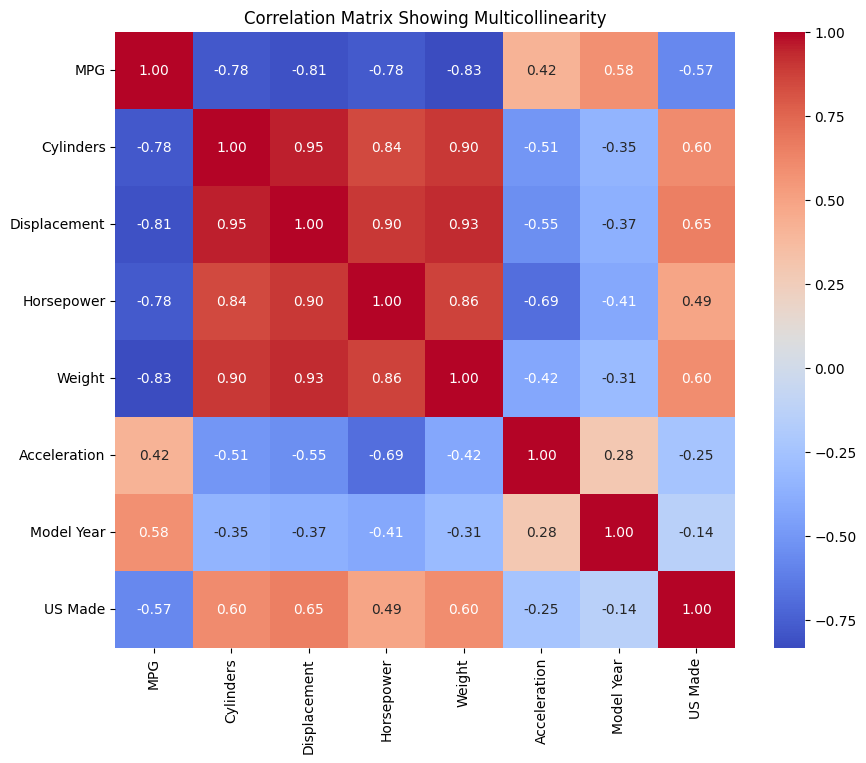

In [5]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Showing Multicollinearity')
plt.show()


## Step 5: Linear Regression Model Building and Evaluation
Now that the dataset has been cleaned and multicollinearity has been addressed, we build a linear regression model to predict MPG. The independent variables selected are Horsepower, Weight, Acceleration, Model Year, and US Made. We evaluate the model using two key metrics: RMSE (Root Mean Squared Error) and R² (Coefficient of Determination). RMSE tells us how far our predictions are from the actual MPG values, while R² tells us how much variance in MPG is explained by the model.


In [6]:
# Build the model
X = df[['Horsepower', 'Weight', 'Acceleration', 'Model Year', 'US Made']]
y = df['MPG']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Coefficients of the model
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
coefficients


RMSE: 2.920481963627486
R²: 0.8395289453159859


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Feature,Coefficient
0,Horsepower,-0.001605
1,Weight,-0.005878
2,Acceleration,0.033436
3,Model Year,0.790764
4,US Made,-2.130439


## Step 6: Visualizing Results
Below is a scatter plot showing the actual MPG values compared to the predicted MPG values. This visualization helps us assess how well the model is performing and whether it is making accurate predictions.


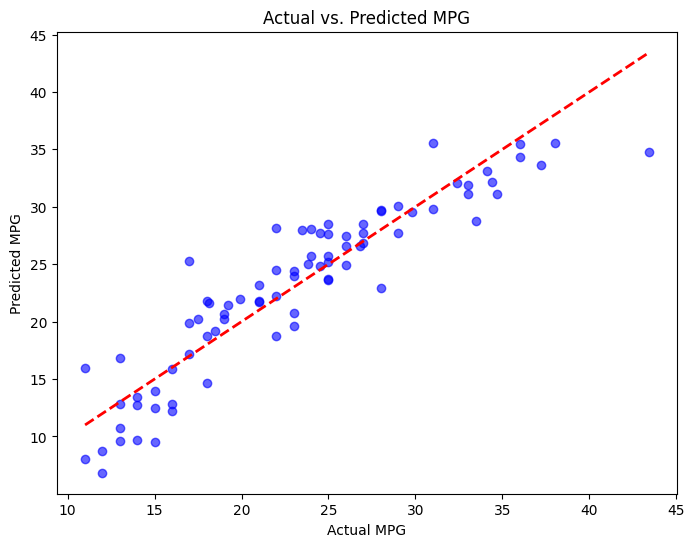

In [7]:
# Actual vs. Predicted MPG plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('Actual vs. Predicted MPG')
plt.show()


## Conclusion
The analysis shows that reducing vehicle weight, optimizing horsepower, and leveraging newer technologies are key factors for improving fuel efficiency (MPG). The linear regression model performed well with an R² score of 0.84, meaning it explains 84% of the variance in MPG. This provides the car manufacturer with actionable insights to design more fuel-efficient vehicles.
